<a href="https://colab.research.google.com/github/TAUforPython/fuzzy/blob/main/Fuzzy_Motor_PID_controller.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/allonios/fuzzy-pid

In [1]:
! pip install -U scikit-fuzzy

In [2]:
import numpy as np
import skfuzzy as fuzz
from matplotlib import pyplot as plt
from skfuzzy import control as ctrl

In [30]:
class FuzzyErrorController:
    def __init__(self, plot_functions: bool = False) -> None:
        self.plot_functions = plot_functions

        self.controller = ctrl.ControlSystem()
        self.rules = []
        self.simulation = ctrl.ControlSystemSimulation(self.controller)

    def get_gain(self, error: float) -> float:
        self.simulation.input["error"] = error
        self.simulation.compute()
        return self.simulation.output["gain"]


class FuzzyProportionalController(FuzzyErrorController):
    def __init__(self, plot_functions: bool = False) -> None:
        super().__init__(plot_functions)

        # Input.
        self.error = ctrl.Antecedent(np.arange(0, 100, 1), "error")

        # Output.
        self.gain = ctrl.Consequent(np.arange(0, 3, 0.5), "gain")

        # Input Membership Functions.
        self.error["small"] = fuzz.trimf(self.error.universe, [0, 0, 30])
        self.error["medium"] = fuzz.trimf(self.error.universe, [10, 40, 80])
        self.error["large"] = fuzz.trimf(self.error.universe, [60, 100, 100])

        # Output Membership Functions.
        self.gain["small"] = fuzz.trimf(self.gain.universe, [0, 0, 2])
        self.gain["medium"] = fuzz.trimf(self.gain.universe, [0.5, 1.5, 2.5])
        self.gain["large"] = fuzz.trimf(self.gain.universe, [1, 3, 3])

        if self.plot_functions:
            self.error.view()
            self.gain.view()
            plt.show()

        # Rules
        rule1 = ctrl.Rule(self.error["small"], self.gain["large"])
        rule2 = ctrl.Rule(self.error["medium"], self.gain["small"])
        rule3 = ctrl.Rule(self.error["large"], self.gain["small"])


        self.rules = [rule1, rule2, rule3, ]

        for rule in self.rules:
            self.controller.addrule(rule)

        self.simulation = ctrl.ControlSystemSimulation(self.controller)


class FuzzyIntegralController(FuzzyErrorController):
    def __init__(self, plot_functions: bool = False):
        super().__init__(plot_functions)

        # Input.
        self.error = ctrl.Antecedent(np.arange(0, 100, 1), "error")

        # Output.
        self.gain = ctrl.Consequent(np.arange(0.01, 0.1, 0.01), "gain")

        # Input Membership Functions.
        self.error["small"] = fuzz.trimf(self.error.universe, [0, 0, 30])
        self.error["medium"] = fuzz.trimf(self.error.universe, [10, 40, 80])
        self.error["large"] = fuzz.trimf(self.error.universe, [60, 100, 100])

        # Output Membership Functions.
        self.gain["small"] = fuzz.trimf(self.gain.universe, [0, 0, 0.04])
        self.gain["medium"] = fuzz.trimf(self.gain.universe, [0.02, 0.06, 0.1])
        self.gain["large"] = fuzz.trimf(self.gain.universe, [0.08, 0.1, 0.1])

        if self.plot_functions:
            self.error.view()
            self.gain.view()
            plt.show()

        # Rules
        rule1 = ctrl.Rule(self.error["small"], self.gain["small"])
        rule2 = ctrl.Rule(self.error["medium"], self.gain["medium"])
        rule3 = ctrl.Rule(self.error["large"], self.gain["large"])

        self.rules = [rule1, rule2, rule3, ]

        for rule in self.rules:
            self.controller.addrule(rule)

        self.simulation = ctrl.ControlSystemSimulation(self.controller)

In [4]:
from multiprocessing import Queue
from time import sleep
from typing import List

In [5]:
class SimpleMotor:
    """
    A class to simulate a DC motor with a slowing factor to add a realistic
    specs for a real world situation.
    """

    def __init__(
            self,
            initial_rpm: float = 0,
            target_rpm: float = 2,
            voltage: float = 5,
            current: float = 100,
            radius: float = 15,
            mass: float = .5,
            slowing_factor: float = 0.1,
            iterations_limit: int = 20,
    ) -> None:
        """
        :param initial_rpm: initial motor speed.
        :param target_rpm: motor desired speed.
        :param voltage: initial motor voltage.
        :param current: initial motor current.
        :param radius: rotor blades length.
        :param mass: rotor blades mass.
        :param slowing_factor: a slowing factor that represents outer
        conditions like air speed, friction, etc.
        """
        self.rpm = initial_rpm
        self.target_rpm = target_rpm
        self.voltage = voltage
        self.current = current
        self.radius = radius
        self.mass = mass
        self.force = 0
        self.tau = 0
        self.acc = 0
        self.status = False

        self.slowing_factor = slowing_factor

        self.iterations_limit = iterations_limit


    def calculate_force(self) -> float:
        self.force = self.voltage * self.current
        return self.force

    def calculate_torque(self):
        self.tau = self.radius * self.force
        return self.tau

    def calculate_acceleration(self) -> float:
        self.acc = self.force / (self.mass * (self.radius ** 2))
        return self.acc

    def apply_slowing_factor(self):
        self.rpm -= self.rpm * self.slowing_factor

    def run(
            self,
            plot: bool = True,
            mulprocess_queue: Queue = None,
    ):
        voltage = self.voltage

        iterations_counter = 0
        rpm_history = []
        while True:
            #print(f"RPM {self.rpm} Target RPM {self.target_rpm}")
            #print(f"{self.force=}")
            #print(f"{self.tau=}")
            #print(f"{self.acc=}")
            #print("==========================================================")

            self.calculate_force()
            self.calculate_torque()
            self.rpm += self.calculate_acceleration()
            rpm_history.append(self.rpm)

            self.apply_slowing_factor()

            sleep(.1)

            if plot:
                plt.pause(.1)
                plt.plot(rpm_history, color="blue")

            if self.rpm >= self.target_rpm:
                self.voltage = 0
            else:
                self.voltage = voltage

            iterations_counter += 1
            if self.iterations_limit == iterations_counter:
                break
        if mulprocess_queue:
            mulprocess_queue.put(
                {
                    "simple_motor": rpm_history
                }
            )
        return rpm_history


class PIDMotor(SimpleMotor):
    """
    A class to simulate a DC motor with a slowing factor to add a realistic
    specs for a real world situation using a PID controller.
    """

    def __init__(
            self,
            initial_rpm: float = 0,
            target_rpm: float = 2,
            voltage: float = 5,
            current: float = 100,
            radius: float = 15,
            mass: float = .5,
            slowing_factor: float = 0.1,
            iterations_limit: int = 20,
            k_p: float = 1,
            k_i: float = 0,
            k_d: float = 0
    ) -> None:
        super().__init__(
            initial_rpm,
            target_rpm,
            voltage,
            current,
            radius,
            mass,
            slowing_factor,
            iterations_limit,
        )

        self.k_p = k_p
        self.k_i = k_i
        self.k_d = k_d

    def run(
            self,
            plot: bool = True,
            mulprocess_queue: Queue = None,
    ) -> List[float]:
        # PID variables.
        integral = 0
        last_error = 0

        iterations_counter = 0
        rpm_history = []
        while True:
            #print(f"RPM {self.rpm} Target RPM {self.target_rpm}")
            #print(f"{self.force=}")
            #print(f"{self.tau=}")
            #print(f"{self.acc=}")
            #print("==========================================================")

            # calculate PID.
            error = self.target_rpm - self.rpm
            integral += error
            derivative = error - last_error
            last_error = error

            self.voltage = (
                    (error * self.k_p)
                    + (integral * self.k_i)
                    + (derivative * self.k_d)
            )

            self.calculate_force()
            self.calculate_torque()
            self.rpm += self.calculate_acceleration()
            rpm_history.append(self.rpm)

            self.apply_slowing_factor()

            sleep(.1)

            if plot:
                plt.pause(.1)
                plt.plot(rpm_history, color="blue")

            iterations_counter += 1
            if self.iterations_limit == iterations_counter:
                break
        if mulprocess_queue:
            mulprocess_queue.put(
                {
                    "pid_motor": rpm_history
                }
            )
        return rpm_history


class FuzzyPIDMotor(SimpleMotor):
    """
    A class to simulate a DC motor with a slowing factor to add a realistic
    specs for a real world situation using a Fuzzy PID controller.
    """

    def __init__(
            self,
            initial_rpm: float = 0,
            target_rpm: float = 2,
            voltage: float = 5,
            current: float = 100,
            radius: float = 15,
            mass: float = .5,
            slowing_factor: float = 0.1,
            iterations_limit: int = 20,
            plot_functions: bool = False
    ) -> None:
        super().__init__(
            initial_rpm,
            target_rpm,
            voltage,
            current,
            radius,
            mass,
            slowing_factor,
            iterations_limit,
        )
        self.fuzzy_proportional_controller = FuzzyProportionalController(
            plot_functions=plot_functions
        )
        self.fuzzy_integral_controller = FuzzyIntegralController(
            plot_functions=plot_functions
        )

    def run(
            self,
            plot: bool = True,
            mulprocess_queue: Queue = None,
    ) -> List[float]:
        # PID variables.
        integral = 0
        last_error = 0

        iterations_counter = 0
        rpm_history = []
        while True:
            #print(f"RPM {self.rpm} Target RPM {self.target_rpm}")
            #print(f"{self.force=}")
            #print(f"{self.tau=}")
            #print(f"{self.acc=}")

            # calculate PID.
            error = self.target_rpm - self.rpm
            integral += error
            derivative = error - last_error
            last_error = error


            k_p = self.fuzzy_proportional_controller.get_gain(error)
            k_i = self.fuzzy_integral_controller.get_gain(error)

            #print(f"{error=}")
            #print(f"{k_p=}")
            #print(f"{k_i=}")
            #print("==========================================================")

            self.voltage = (
                    (error * k_p)
                    + (integral * k_i)
                    + (derivative * 0)
            )

            self.calculate_force()
            self.calculate_torque()
            self.rpm += self.calculate_acceleration()
            rpm_history.append(self.rpm)

            self.apply_slowing_factor()

            sleep(.1)

            if plot:
                plt.pause(.1)
                plt.plot(rpm_history, color="blue")

            iterations_counter += 1
            if self.iterations_limit == iterations_counter:
                break
        if mulprocess_queue:
            mulprocess_queue.put(
                {
                    "fuzzy_pid_motor": rpm_history
                }
            )
        return rpm_history

In [31]:
    config = {
        "target_rpm": 70,
        "iterations_limit": 30,
    }

    simple_motor = SimpleMotor(**config)

    pid_motor = PIDMotor(
        **config,
        k_p=2,
        k_i=0.01,
        k_d=0.1,
    )

    fuzzy_pid_motor = FuzzyPIDMotor(**config, plot_functions=False)

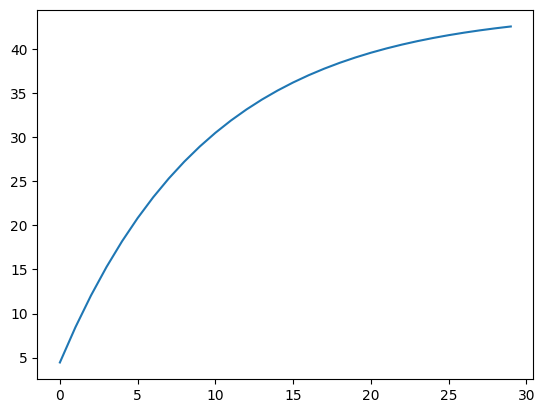

In [15]:
simple_motor_rpm_history = simple_motor.run(plot = False)
plt.plot(simple_motor_rpm_history)

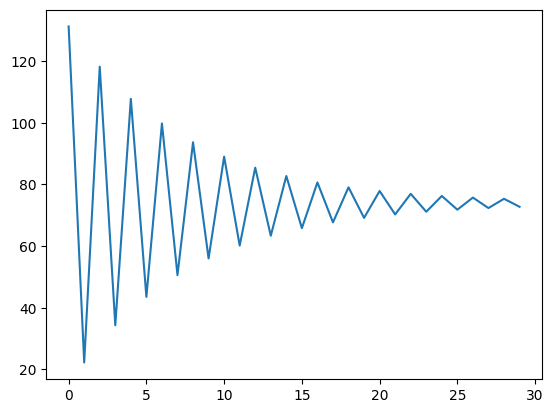

In [16]:
pid_motor_rpm_history = pid_motor.run(plot = False)
plt.plot(pid_motor_rpm_history)

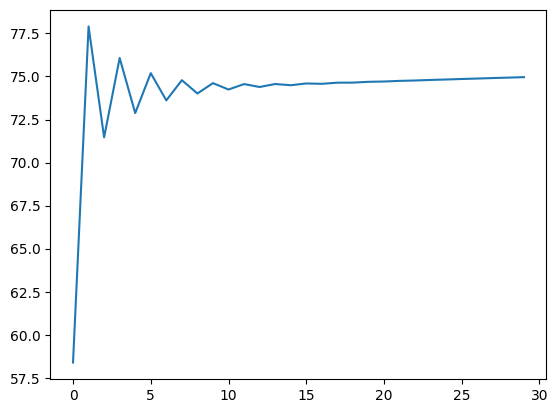

In [32]:
 fuzzy_pid_motor_rpm_history = fuzzy_pid_motor.run(plot = False)
 plt.plot(fuzzy_pid_motor_rpm_history)

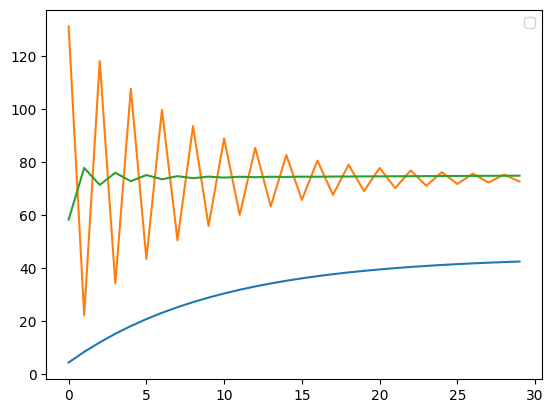

In [33]:
plt.plot(simple_motor_rpm_history)
plt.plot(pid_motor_rpm_history)
plt.plot(fuzzy_pid_motor_rpm_history)
plt.legend()
plt.show()